# T8 - Immunity methods

This tutorial covers several of the features new to Covasim 3.0, including waning immunity, multi-variant modelling, and advanced vaccination methods.

## Using waning immunity

By default, immunity is assumed to grow and then wane over time according to a two-part exponential decay of neutralizing antibodies. This can be changed by setting `use_waning=False`, such that infection is assumed to confer lifelong perfect immunity, meaning that people who have been infected cannot be infected again.
When `use_waning` is set to True, agents in the simulation are assigned a peak level of neutralizing antibodies upon infection or vaccination, drawn from a distribution defined in the parameter dictionary.
This level grows to its peak and then decays over time, leading to declines in the efficacy of protection against infection, symptoms, and severe symptoms.
The following example creates simulations without waning immunity, and compares it to simulations with different speeds of immunity waning.

Covasim 3.1.0 (2021-08-30) — © 2021 by IDM


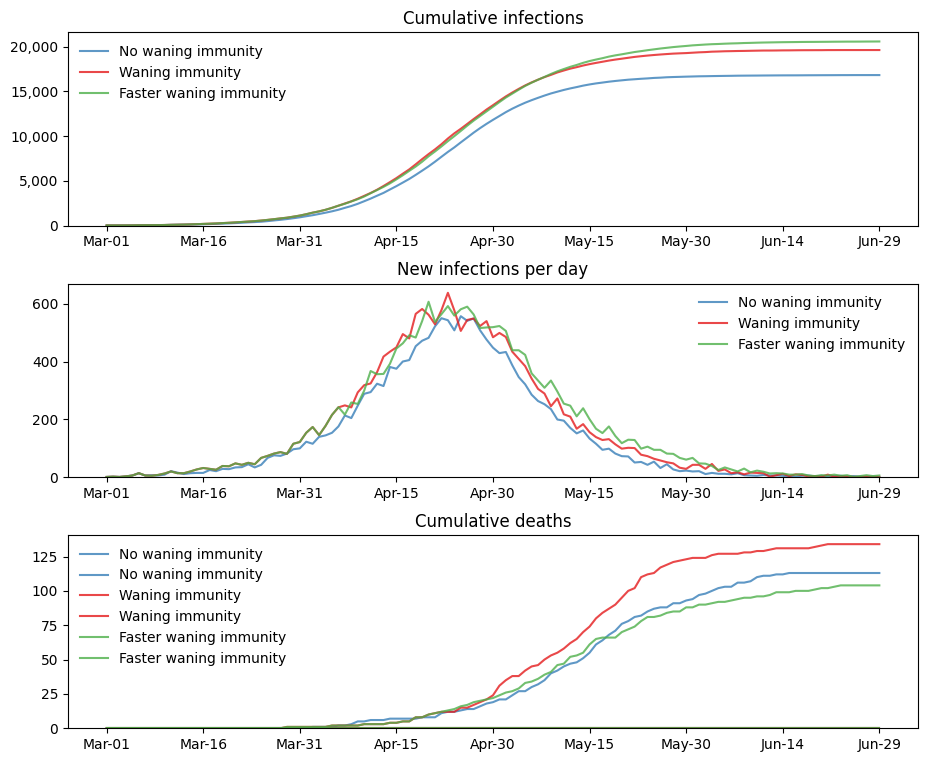

In [1]:
import numpy as np
import sciris as sc
import covasim as cv
import pylab as pl
cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

# Create sims with and without waning immunity
sim_nowaning = cv.Sim(n_days=120, use_waning=False, label='No waning immunity')
sim_waning = cv.Sim(n_days=120, label='Waning immunity')

# Now create an alternative sim with faster decay for neutralizing antibodies
sim_fasterwaning = cv.Sim(
    label='Faster waning immunity',
    n_days=120,
    nab_decay=dict(form='nab_growth_decay', growth_time=21, decay_rate1=0.07, decay_time1=47, decay_rate2=0.02, decay_time2=106)
)


# Create a multisim, run, and plot results
msim = cv.MultiSim([sim_nowaning, sim_waning, sim_fasterwaning])
msim.run()
msim.plot()

## Multi-variant modeling

The next examples show how to introduce new variants into a simulation.
These can either be known variants of concern, or custom new variants.
New variants may have differing levels of transmissibility, symptomaticity, severity, and mortality.
When introducing new variants, `use_waning` must be set to `True`.
The model includes known information about the levels of cross-immunity between different variants.
Cross-immunity can also be manually adjusted.

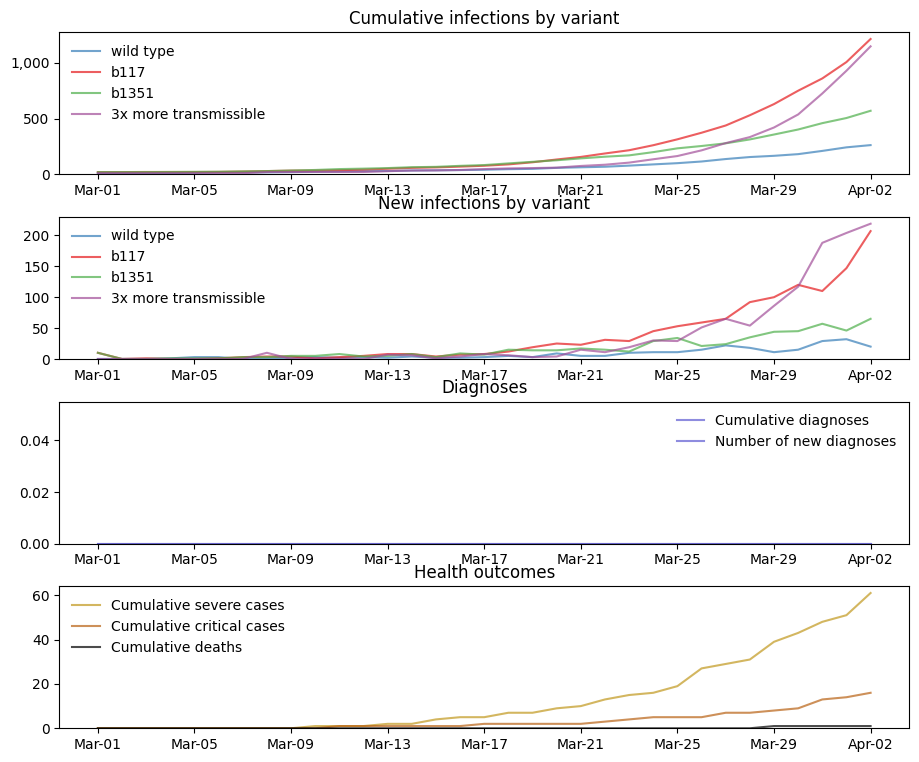

In [2]:
# Define three new variants: B117, B1351, and a custom-defined variant
b117    = cv.variant('b117', days=0, n_imports=10)
b1351   = cv.variant('b1351', days=0, n_imports=10)
custom  = cv.variant(label='3x more transmissible', variant={'rel_beta': 3.0}, days=7, n_imports=10)

# Create the simulation
sim = cv.Sim(variants=[b117, b1351, custom], pop_infected=10, n_days=32)

# Run and plot
sim.run()
sim.plot('variant')

## Advanced vaccination methods

The intervention `cv.BaseVaccination` allows you to introduce a selection of known vaccines into the model, each of which is pre-populated with known parameters on their efficacy against different variants, their durations of protection, and the levels of protection that they afford against infection and disease progression. The prioritization of vaccines is implemented with derived classes that implement specific allocation algorithms. Covasim 3.0 comes with two such algorithms:

- `cv.vaccinate_prob()` - specify a daily probability of vaccination for each person
- `cv.vaccinate_num()` - specify a sequence of people to vaccinate, and the number of available doses each day

When using any of these vaccination interventions, `use_waning` must be set to `True`.

### Probability -based vaccination

The intervention `cv.vaccinate_prob()` allows you specify the daily probability that each individual gets vaccinated. The following example illustrates how to use the `cv.vaccinate_prob()` intervention.

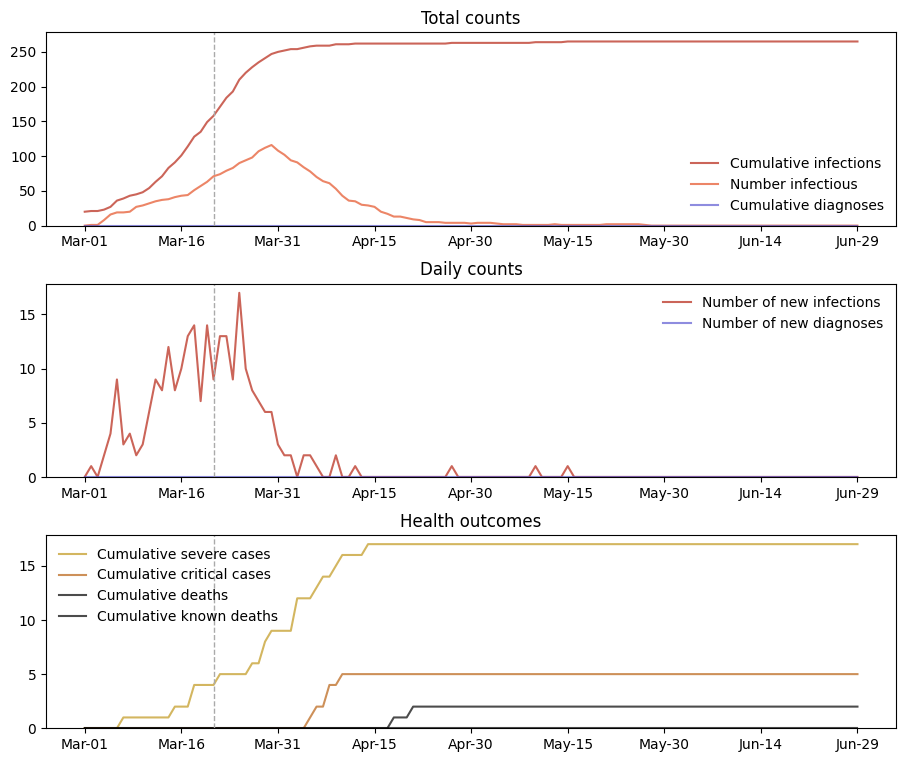

In [3]:
# Create some base parameters
pars = {
    'beta': 0.015,
    'n_days': 120,
}

# Define probability based vaccination
pfizer = cv.vaccinate_prob(vaccine='pfizer', days=20)
sim = cv.Sim(
    pars=pars,
    interventions=pfizer
)
sim.run()
sim.plot()

### Sequence-based vaccination

To use `cv.vaccinate_num`, it is necessary to specify the vaccine prioritization - for example, this may involve defining priority groups like 1A, 1B etc. depending on the setting. The vaccine prioritization is specified as an ordered sequence of people to vaccinate, so in almost all cases, a function can be defined that takes in a `cv.People` instance, and returns an array of indices specifying the order in which people get vaccinated. This function could also incorporate steps such as randomizing the order of people within priority groups, or removing some people from the sequence to account for vaccine hesitancy and peak coverage not reaching 100%. A simple example of a prioritization function would be to simply sort by age in descending order i.e.

In [4]:
def prioritize_by_age(people):
    return np.argsort(-people.age)

This function can be passed to `cv.vaccinate_num` where it will be evaluated during initialization, and therefore will run after the population has been generated. In cases where the `cv.People` have been generated offline and are being loaded instead of generated, it's possible to pass a pre-computed sequence of indices to `cv.vaccinate_num` rather than a prioritization function that returns the sequence. 

The example below also shows how to use a simple `Analyzer` to capture additional information about the vaccine state each timestep.

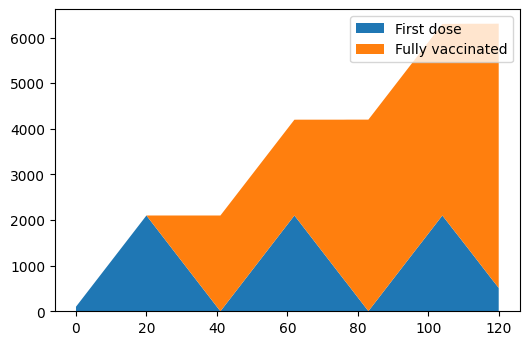

In [5]:
# Record the number of doses each person has recieved each day so
# that we can plot the rollout in this example. Without a custom 
# analyzer, only the total number of doses will be recorded
n_doses = [] 

# Define sequence based vaccination
pfizer = cv.vaccinate_num(vaccine='pfizer', sequence=prioritize_by_age, num_doses=100)
sim = cv.Sim(
    pars=pars,
    interventions=pfizer,
    analyzers=lambda sim: n_doses.append(sim.people.vaccinations.copy())
)
sim.run()

pl.figure()
n_doses = np.array(n_doses)
fully_vaccinated = (n_doses == 2).sum(axis=1)
first_dose = (n_doses == 1).sum(axis=1)
pl.stackplot(sim.tvec, first_dose, fully_vaccinated)
pl.legend(['First dose','Fully vaccinated'])

Notice how second doses are prioritized, so after 21 days, there is a backlog of people requiring second doses, so the first doses are suspended until all of the second doses have been delivered. In reality, the pace of vaccination typically increases following the commencement of vaccination, so capacity increases over time. The `doses_per_day` argument allows this increase to be captured. There are several ways to specify a time-varying dose, including a date-based dictionary to facilitate calibration when the number of doses each day is known. A simple option is to use a function that returns the number of doses to distribute based on the `cv.Sim` - for example:

In [6]:
def num_doses(sim):
    if sim.t < 50:
        return sim.t*10
    else:
        return 500

This function corresponds to the vaccination rate increasing linearly for the first 50 days, before then stabilizing. The function can be passed directly into the `cv.vaccinate_num` intervention:

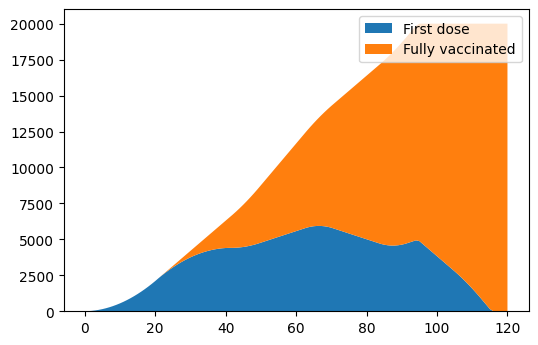

In [7]:
n_doses = [] 
pfizer = cv.vaccinate_num(vaccine='pfizer', sequence=prioritize_by_age, num_doses=num_doses)
sim = cv.Sim(
    pars=pars,
    interventions=pfizer,
    analyzers=lambda sim: n_doses.append(sim.people.vaccinations.copy())
)
sim.run()

pl.figure()
n_doses = np.array(n_doses)
fully_vaccinated = (n_doses == 2).sum(axis=1)
first_dose = (n_doses == 1).sum(axis=1)
pl.stackplot(sim.tvec, first_dose, fully_vaccinated)
pl.legend(['First dose','Fully vaccinated']);

Now the increase in capacity means that when second doses are due, there are sufficient additional doses available to continue distributing first doses. Further customization, particularly to customize second dose prioritization depending on the specific policies implemented in a particular setting, can be readily achieved by implementing a new class deriving from `cv.BaseVaccination` in exactly the same way `cv.vaccinate_prob` and `cv.vaccinate_num` are implemented. 

### Boosters

By default, the vaccination interventions in Covasim are targeted towards unvaccinated people. If you want to include boosters in your simulation, you can use the `booster=True` argument when calling `cv.vaccinate`. You also need to use the `subtarget` argument so that we know who is going to receive a booster shot:

In [ ]:
# Define the number of boosters
def num_boosters(sim):
    if sim.t < 100: # None over the first 100 days
        return 0
    else:
        return 100 # Then 100/day thereafter

# Only give boosters to people who have had 2 doses
booster_target  = {'inds': lambda sim: cv.true(sim.people.vaccinations != 2), 'vals': 0}
booster = cv.vaccinate_num(vaccine=booster, sequence=prioritize_by_age, subtarget=booster_target, booster=True, num_doses=num_boosters)

# Track doses
n_doses = []
n_doses_boosters = []

# Create a sim with boosters
sim_booster = cv.Sim(use_waning=True, pars=base_pars,
                      interventions=[pfizer, booster],
                      label='With booster',
                      analyzers=lambda sim: n_doses_boosters.append(sim.people.vaccinations.copy())
                      )
sim_booster.run()

# Plot the sims with and without boosters together
cv.MultiSim([sim, sim_booster]).plot(to_plot=['cum_infections', 'cum_severe', 'cum_deaths','pop_nabs'])

# Plot doses again
pl.figure()
n_doses = np.array(n_doses_boosters)
fully_vaccinated = (n_doses == 2).sum(axis=1)
first_dose = (n_doses == 1).sum(axis=1)
boosted = (n_doses > 2).sum(axis=1)
pl.stackplot(sim.tvec, first_dose, fully_vaccinated, boosted)
pl.legend(['First dose', 'Fully vaccinated', 'Boosted']);
pl.show()

In this example there isn't a large difference in the epidemic dynamics, because over a short run-time (120 days) immunity doesn't wane very much, so boosters don't have a large effect. However, this example can be adapted to longer run-times, where boosters have a larger impact.

### Prior immunity methods

The longer that the COVID-19 pandemic persists, the less feasible/desirable it becomes to simulate the entire ~2 year history of the epidemic. However, starting simulations 1-2 years into the pandemic is also not ideal, as this will fail to capture the pre-existing immunity profile of the population. A good alternative is to use the `cv.prior_immunity` method. The following example starts a simulation in which 50% of the population are assumed to be vaccinated with the Pfizer vaccine 360 days before the simulation begins:

In [ ]:
pfizer = cv.historical_vaccinate_prob(vaccine='pfizer', days=[-360], prob=0.5)
sim = cv.Sim(pars={'n_days':1}, interventions=pfizer, use_waning=True,
             analyzers=cv.nab_histogram(days=[0], edges=np.linspace(-4,2,12+1)))
sim.run()

sim['analyzers'][0].plot()

The histogram of neutralizing antibody levels after 1 day of simulation shows that there are already significant levels of immunity in the population.

This next example will initialize the population with immunity levels corresponding to a prior wave of infections peaking 120 days before the simulation starts, with 5% of the population having been infected:

In [ ]:
intv = cv.prior_immunity(120, 0.05)
cv.Sim(pars={'use_waning':True}, interventions=intv).run().plot()